In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import spacy
import matplotlib.pyplot as plt

In [2]:
text_data = pd.read_csv('../speeches_millercenter_preprocessed.csv')

In [3]:
text_data.head(2)

,Transcript,Summary,President,Source,Date,URL,Word Count,Affiliation,Label
0,34th time speak oval office year soon time wan...,"In this broadcast from the Oval Office, Presid...",Ronald Reagan,National Archives,"January 11, 1989",https://millercenter.org/the-presidency/presid...,3289,Republican,0
1,thank warm welcome governor baliles congress...,NaN,Ronald Reagan,NaN,"December 16, 1988",https://millercenter.org/the-presidency/presid...,7127,Republican,0


In [7]:
# Download vectors: https://spacy.io/models/en-starters#en_vectors_web_lg
nlp = spacy.load('en_vectors_web_lg')
total_vectors = len(nlp.vocab.vectors)
print('Total word vectors:', total_vectors)

Total word vectors: 1070971


In [8]:
# Preparing smaller subset of data for TSNE
counts = text_data.Transcript.str.split(expand=True).stack().value_counts().to_frame().iloc[0:100]
common_words = counts.index.to_list()
common_words_vectors = np.array([nlp(word).vector for word in common_words])

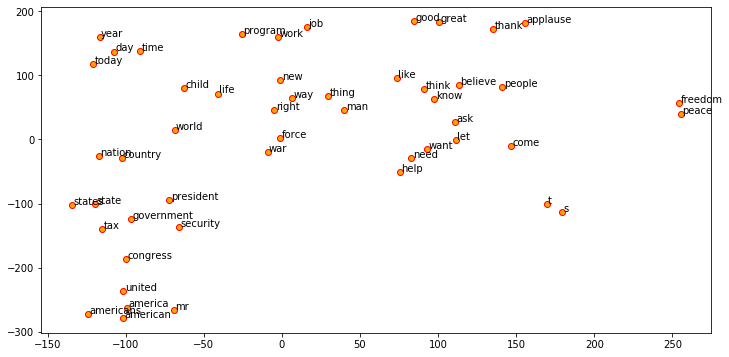

In [9]:
# This is visualizing the vector space of the 50 most common words in the speeches,
# using the pre-trained vectors from SpaCy

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=3)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(common_words_vectors[:50])
labels = common_words[:50]
plt.figure(figsize=(12, 6))
plt.scatter(T[:, 0], T[:, 1], c="orange", edgecolors="r")
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

In [10]:
# train test split
from sklearn.model_selection import train_test_split
train_corpus, test_corpus, train_label_nums, test_label_nums, train_label_names, test_label_names = train_test_split(text_data['Transcript'],
                                         np.array(text_data['Label']),
                                         np.array(text_data['Affiliation']),
                                         test_size=0.33, random_state=42)
train_corpus.shape, test_corpus.shape

((261,), (130,))

In [11]:
# Input of classification models will have to be an array of arrays, where each array
# is a fixed-length array (300) obtained by averaging the vectors of each documents

In [12]:
def vectorize_corpus(corpus):
    '''Takes a list of documents and returns a list of vectors for each document,
    built by vectorizing each word in each document, and then averaging the document's
    word's vectors'''
    doc_words = [list(set(document.split())) for document in corpus]
    words_vectors = [np.array([nlp(word).vector for word in document]) for document in doc_words]
    doc_vectors = [np.mean(vec, axis=0) for vec in words_vectors]
    print("Returned {} documents, each as a vector of len {}".format(len(doc_vectors), len(doc_vectors[0])))
    return doc_vectors

In [13]:
train_vectors = vectorize_corpus(train_corpus)
test_vectors = vectorize_corpus(test_corpus)

Returned 261 documents, each as a vector of len 300
Returned 130 documents, each as a vector of len 300


In [14]:
# Nifty trick to test length of spacy vectors
nlp('hello').vector.shape

(300,)

In [15]:
# Passing these vectors to ML classification models

In [16]:
# Not NaiveBayes because we have negative values

In [17]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
lr = LogisticRegression(penalty='l2', max_iter=100, C=1, random_state=42)
lr.fit(train_vectors, train_label_names)
lr_tfidf_cv_scores = cross_val_score(lr, train_vectors, train_label_names, cv=5)
lr_tfidf_cv_mean_score = np.mean(lr_tfidf_cv_scores)
print('CV Accuracy (5-fold):', lr_tfidf_cv_scores)
print('Mean CV Accuracy:', lr_tfidf_cv_mean_score)
lr_tfidf_test_score = lr.score(test_vectors, test_label_names)
print('Test Accuracy:', lr_tfidf_test_score)

CV Accuracy (5-fold): [0.64150943 0.71153846 0.65384615 0.67307692 0.63461538]
Mean CV Accuracy: 0.6629172714078375
Test Accuracy: 0.6076923076923076


In [18]:
# Support Vector Machines
from sklearn.svm import LinearSVC
svm = LinearSVC(penalty='l2', C=1, random_state=42)
svm.fit(train_vectors, train_label_names)
svm_tfidf_cv_scores = cross_val_score(svm, train_vectors, train_label_names, cv=5)
svm_tfidf_cv_mean_score = np.mean(svm_tfidf_cv_scores)
print('CV Accuracy (5-fold):', svm_tfidf_cv_scores)
print('Mean CV Accuracy:', svm_tfidf_cv_mean_score)
svm_tfidf_test_score = svm.score(test_vectors, test_label_names)
print('Test Accuracy:', svm_tfidf_test_score)

CV Accuracy (5-fold): [0.75471698 0.80769231 0.67307692 0.73076923 0.78846154]
Mean CV Accuracy: 0.750943396226415
Test Accuracy: 0.7


In [19]:
# SVM with Stochastic Gradient Descent
from sklearn.linear_model import SGDClassifier
svm_sgd = SGDClassifier(loss='hinge', penalty="l2", max_iter=5, random_state=42)
svm_sgd.fit(train_vectors, train_label_names)
svmsgd_tfidf_cv_scores = cross_val_score(svm_sgd, train_vectors, train_label_names, cv=5)
svmsgd_tfidf_cv_mean_score = np.mean(svmsgd_tfidf_cv_scores)
print('CV Accuracy (5-fold):', svmsgd_tfidf_cv_scores)
print('Mean CV Accuracy:', svmsgd_tfidf_cv_mean_score)
svmsgd_tfidf_test_score = svm_sgd.score(test_vectors, test_label_names)
print('Test Accuracy:', svmsgd_tfidf_test_score)

CV Accuracy (5-fold): [0.64150943 0.69230769 0.36538462 0.42307692 0.36538462]
Mean CV Accuracy: 0.49753265602322205
Test Accuracy: 0.5769230769230769


/opt/anaconda3/envs/nlp_capstone/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/opt/anaconda3/envs/nlp_capstone/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/opt/anaconda3/envs/nlp_capstone/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/opt/anaconda3/envs/nlp_capstone/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve

In [20]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=10, random_state=42)
rfc.fit(train_vectors, train_label_names)
rfc_tfidf_cv_scores = cross_val_score(rfc, train_vectors, train_label_names, cv=5)
rfc_tfidf_cv_mean_score = np.mean(rfc_tfidf_cv_scores)
print('CV Accuracy (5-fold):', rfc_tfidf_cv_scores)
print('Mean CV Accuracy:', rfc_tfidf_cv_mean_score)
rfc_tfidf_test_score = rfc.score(test_vectors, test_label_names)
print('Test Accuracy:', rfc_tfidf_test_score)

CV Accuracy (5-fold): [0.64150943 0.78846154 0.57692308 0.67307692 0.73076923]
Mean CV Accuracy: 0.6821480406386067
Test Accuracy: 0.6846153846153846


In [21]:
# Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(n_estimators=10, random_state=42)
gbc.fit(train_vectors, train_label_names)
gbc_tfidf_cv_scores = cross_val_score(gbc, train_vectors, train_label_names, cv=5)
gbc_tfidf_cv_mean_score = np.mean(gbc_tfidf_cv_scores)
print('CV Accuracy (5-fold):', gbc_tfidf_cv_scores)
print('Mean CV Accuracy:', gbc_tfidf_cv_mean_score)
gbc_tfidf_test_score = gbc.score(test_vectors, test_label_names)
print('Test Accuracy:', gbc_tfidf_test_score)

CV Accuracy (5-fold): [0.71698113 0.75       0.73076923 0.67307692 0.69230769]
Mean CV Accuracy: 0.7126269956458635
Test Accuracy: 0.676923076923077


In [22]:
# Multi-layer perceptron model with TD-IDF - from https://analyticsindiamag.com/a-beginners-guide-to-scikit-learns-mlpclassifier/
from sklearn.neural_network import MLPClassifier
#Initializing the MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(150,100,50), max_iter=300,activation = 'relu',solver='adam',random_state=1)
mlp.fit(train_vectors, train_label_names)
mlp_tv_scores = cross_val_score(mlp, train_vectors, train_label_names, cv=5)
mlp_tv_mean_score = np.mean(mlp_tv_scores)
print('CV Accuracy (5-fold):', mlp_tv_scores)
print('Mean CV Accuracy:', np.mean(mlp_tv_scores))
mlp_tv_test_score = mlp.score(test_vectors, test_label_names)
print('Test Accuracy:', mlp_tv_test_score)

/opt/anaconda3/envs/nlp_capstone/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


CV Accuracy (5-fold): [0.86792453 0.75       0.75       0.84615385 0.82692308]
Mean CV Accuracy: 0.8082002902757621
Test Accuracy: 0.7923076923076923


In [23]:
results = pd.DataFrame([
              [lr_tfidf_cv_mean_score, lr_tfidf_test_score],
              [svm_tfidf_cv_mean_score, svm_tfidf_test_score],
              [svmsgd_tfidf_cv_mean_score, svmsgd_tfidf_test_score],
              [rfc_tfidf_cv_mean_score, rfc_tfidf_test_score],
              [gbc_tfidf_cv_mean_score, gbc_tfidf_test_score],
              [mlp_tv_mean_score, mlp_tv_test_score]],
              columns=['CV Score (SpaCy vectors)', 'Test Score (SpaCy vectors)'], index=['Logistic Regression',
                                    'Linear SVM', 'SVM Gradient Boosting', 'Random Forest',
                                    'GradientBoostingClassifier', 'Multi-layer pecerptron']
             )
results

,CV Score (SpaCy vectors),Test Score (SpaCy vectors)
Logistic Regression,0.662917,0.607692
Linear SVM,0.750943,0.700000
SVM Gradient Boosting,0.497533,0.576923
Random Forest,0.682148,0.684615
GradientBoostingClassifier,0.712627,0.676923
Multi-layer pecerptron,0.808200,0.792308


[Text(0.5, 0, 'Test Score (SpaCy vectors)'),
 Text(1.5, 0, 'Test Score (SpaCy vectors)')]

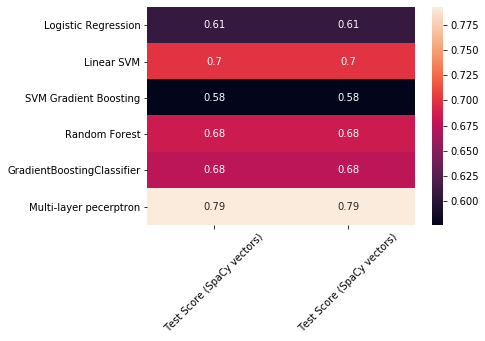

In [25]:
results_test = results[['Test Score (SpaCy vectors)', 'Test Score (SpaCy vectors)']]
chart = sns.heatmap(results_test, annot=True)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)

In [ ]:
# The ML classification models didn't do very well with Spacy vectors.
# Two things can be the reason: 1. Averaging the words' vectors to represent the document
# vector seems like a brittle approach. 2. The words vectors are pre-trained from SpaCy.
# We don't know if those vectors really result in the best vectors for these specific words
# in this specific corpus.
# Is it possible to train your own vectors on this data, and what's the process?